#  Radio Frequency Interference mitigation using deep convolutional neural networks

### This example demonstrates how tf_unet is trained on the 'Bleien Galactic Survey data'. 

To create the training data the SEEK package (https://github.com/cosmo-ethz/seek) has to be installed

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import glob
import tensorflow as tf
plt.rcParams['image.cmap'] = 'gray'

## preparing training data
only one day...

In [2]:
!wget -q -r -nH -np --cut-dirs=2 https://people.phys.ethz.ch/~ipa/cosmo/bgs_example_data/

In [3]:
!mkdir -p bgs_example_data/seek_cache

In [5]:
!seek --file-prefix='./bgs_example_data' --post-processing-prefix='bgs_example_data/seek_cache' --chi-1=20 --overwrite=True seek.config.process_survey_fft

== Ivy run took:  57.897 s ===
Traversing file system        :   0.006s
Generate gain files           :   0.006s
Initialize                    :   0.000s
Load data                     :  14.805s
Convert TOD                   :   0.048s
Process coordinates           :   0.412s
Masking objects               :   0.671s
Masking artefacts             :   0.002s
Remove RFI                    :   9.661s
postprocessing TOD            :   0.045s
remove background baseline    :   0.524s
Restructure TOD               :   0.572s
ParallelPluginCollection      :  26.743s
Create maps                   :   1.681s
ParallelPluginCollection      :   1.760s
Write maps                    :   0.961s


## setting up the unet

In [2]:
import sys 
sys.path.append('/Users/imke/Downloads/tf_unet/tf_unet')
from image_util import ImageDataProvider
import sys 
sys.path.append('/Users/imke/Downloads/tf_unet')
from tf_unet import unet
from tf_unet import util

In [3]:
files = glob.glob('bgs_example_data/seek_cache/*')

In [3]:
data_provider = ImageDataProvider("/Users/imke/Downloads/tina/thinvox/ocn_train_35/*.tif")

net = unet.Unet(channels=data_provider.channels, 
                n_class=data_provider.n_class, 
                layers=3, 
                features_root=64,
                cost_kwargs=dict(regularizer=0.001),
                )

2020-02-05 19:42:43,695 Layers 3, features 64, filter size 3x3, pool size: 2x2


Number of files used: 101
Number of channels: 1
Number of classes: 2
Instructions for updating:
Colocations handled automatically by placer.


2020-02-05 19:42:43,785 From /Users/imke/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/op_def_library.py:263: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


2020-02-05 19:42:43,813 From /Users/imke/Downloads/tf_unet/tf_unet/layers.py:39: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


## training the network
only one epoch. For good results many more are neccessary

In [4]:

trainer = unet.Trainer(net, optimizer="momentum", opt_kwargs=dict(momentum=0.2))
path = trainer.train(data_provider, "./unet_trained_bgs_example_data", 
                     training_iters=2, 
                     epochs=3, 
                     dropout=0.5, 
                     display_step=1,
                    restore = False)



2019-12-30 22:36:58,957 Removing '/Users/imke/Downloads/tf_unet/demo/prediction'
2019-12-30 22:36:58,959 Removing '/Users/imke/Downloads/tf_unet/demo/unet_trained_bgs_example_data'
2019-12-30 22:36:58,960 Allocating '/Users/imke/Downloads/tf_unet/demo/prediction'
2019-12-30 22:36:58,961 Allocating '/Users/imke/Downloads/tf_unet/demo/unet_trained_bgs_example_data'
2019-12-30 22:37:24,812 Verification error= 47.9%, loss= 1.4182
2019-12-30 22:37:25,297 Start optimization
2019-12-30 22:37:47,126 Iter 0, Minibatch Loss= 1.4071, Training Accuracy= 0.8717, Minibatch error= 12.8%
2019-12-30 22:38:06,982 Iter 1, Minibatch Loss= 1.3918, Training Accuracy= 0.8976, Minibatch error= 10.2%
2019-12-30 22:38:06,989 Epoch 0, Average loss: 1.4048, learning rate: 0.0100
2019-12-30 22:38:29,599 Verification error= 13.4%, loss= 1.3941
2019-12-30 22:38:50,590 Iter 0, Minibatch Loss= 1.3806, Training Accuracy= 0.8808, Minibatch error= 11.9%
2019-12-30 22:39:11,423 Iter 1, Minibatch Loss= 1.3723, Training Acc

## running the prediction on the trained unet

In [5]:
data_provider = ImageDataProvider("/Users/imke/Downloads/tina/thinvox/ocn_tf_test_35/*.tif")
x_test, y_test = data_provider(1)
prediction = net.predict('/Users/imke/Downloads/tf_unet/data result/model.ckpt', x_test)
#util.plot_prediction(x_test, y_test, prediction)

Number of files used: 35
Number of channels: 1
Number of classes: 2
Instructions for updating:
Use standard file APIs to check for files with this prefix.


2020-02-05 19:45:40,780 From /Users/imke/anaconda3/lib/python3.7/site-packages/tensorflow/python/training/saver.py:1266: checkpoint_exists (from tensorflow.python.training.checkpoint_management) is deprecated and will be removed in a future version.
Instructions for updating:
Use standard file APIs to check for files with this prefix.


INFO:tensorflow:Restoring parameters from /Users/imke/Downloads/tf_unet/data result/model.ckpt


2020-02-05 19:45:40,784 Restoring parameters from /Users/imke/Downloads/tf_unet/data result/model.ckpt
2020-02-05 19:45:40,938 Model restored from file: /Users/imke/Downloads/tf_unet/data result/model.ckpt


In [43]:
def error_rate(predictions, labels):

    print( 100.0 - (
            100.0 *
            np.sum(np.argmax(predictions, 3) == np.argmax(labels, 3)) /
            (predictions.shape[0] * predictions.shape[1] * predictions.shape[2])))
print (prediction.shape)

#predict = np.zeros((472,472))
for i in range (472):
    for j in range (472):
        if (prediction[0,i,j,0]<prediction[0,i,j,1]):
            predict[i][j] = 1
        else:
            predict[i][j] = 0

print (len(predict))

(1, 472, 472, 2)
472


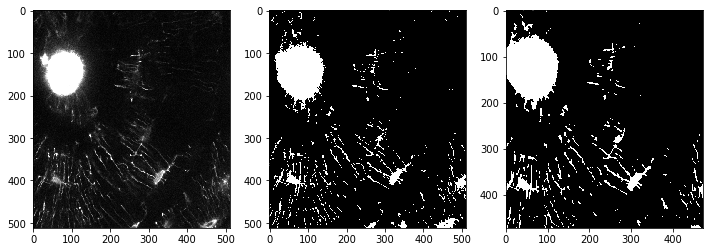

In [44]:
fig, ax = plt.subplots(1,3, figsize=(12,4))
ax[0].imshow(x_test[0,...,0], aspect="auto")
ax[1].imshow(y_test[0,...,1], aspect="auto")
ax[2].imshow(predict, aspect="auto")

AttributeError: 'str' object has no attribute 'astype'

In [16]:
import os
import cv2
import numpy as np

root = '/Users/imke/Downloads/tina/thinvox/prediction_TIF'
files = os.listdir(root)
files.sort()
lens = len(files)
loss = 0
h = 254
for i in range(lens):
    if i%2 == 0:
        gt = cv2.imread(os.path.join(root , files[i]))
        pre = cv2.imread(os.path.join(root , files[i+1]))
        gt = (gt[ : , : , 0]>h)*1
        pre = (pre[ : , : , 1]>h)*1
        loss1 = np.sum(np.abs(gt - pre) )/float(gt.shape[0]*gt.shape[1])
        loss1 = loss1*100
        loss += loss1
loss = loss/35
print ('sum_loss= %f%%'%loss)

ModuleNotFoundError: No module named 'cv2'

In [37]:
import os
from PIL import Image 
#import cv2
import numpy as np

def load(path, dtype=np.float32):
        return np.array(Image.open(path), dtype)
    
def error_rate(predictions, labels):
    return (100.0 - (
            100.0 *
            np.sum(np.argmax(predictions) == np.argmax(labels)) /
            (predictions.shape[0] * predictions.shape[1] )))

root = '/Users/imke/Downloads/tina/thinvox/prediction_TIF_copy'
files = os.listdir(root)
files.sort()
lens = len(files)a
loss = 0
for i in range(lens):
    if i%2 == 0:
        gt = load(os.path.join(root , files[i]),np.int)
        pre = load(os.path.join(root , files[i+1]),np.int)
        loss1 = error_rate(gt, pre)
        #print(loss1)
        loss += loss1
loss = loss/35
print ('sum_loss= %f%%'%loss)

sum_loss= 99.999978%


loss1=	2.7348%
loss2=	2.7489%
loss3=	2.7893%
loss4=	2.8587%
loss5=	2.8564%
loss6=	2.8233%
loss7=	2.7431%
loss8=	2.7336%
loss9=	2.6978%
loss10=	2.7222%
loss11=	2.7657%
loss12=	2.6947%
loss13=	2.5341%
loss14=	2.5581%
loss15=	2.5719%
loss16=	2.6299%
loss17=	2.6455%
loss18=	2.6173%
loss19=	2.6783%
loss20=	2.7016%
loss21=	2.6512%
loss22=	2.5524%
loss23=	2.4582%


/Users/imke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:27: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


loss24=	2.3895%
loss25=	2.4582%
loss26=	2.3979%
loss27=	2.4006%
loss28=	2.4231%
loss29=	2.3724%
loss30=	2.2560%
loss31=	2.2430%
loss32=	2.1988%
loss33=	2.2240%
loss34=	2.2530%
loss35=	2.2121%
sum_loss=	2.5599%


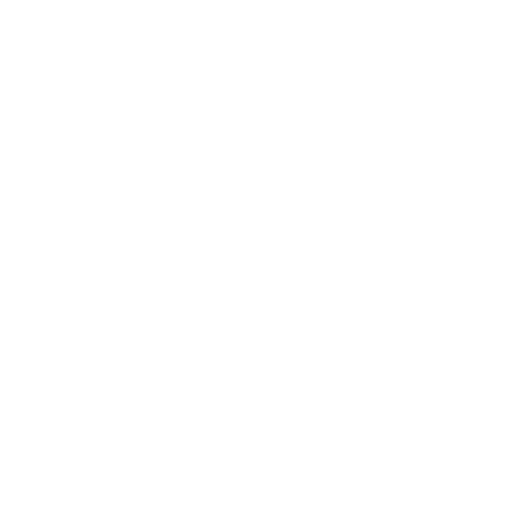

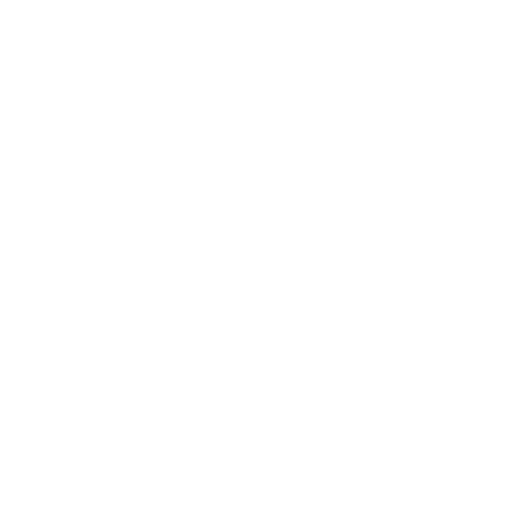

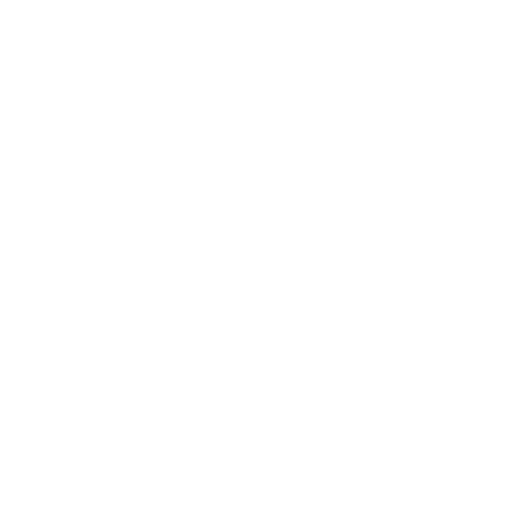

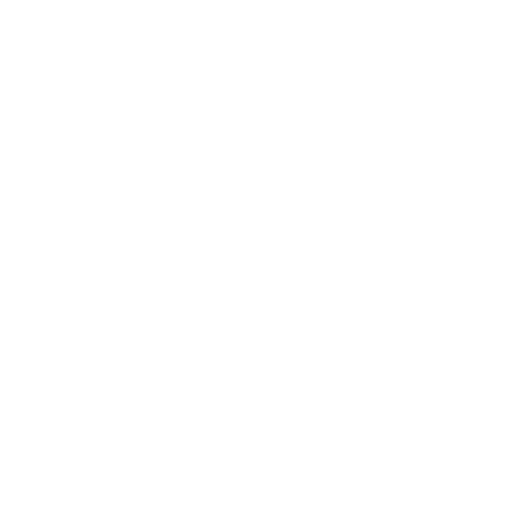

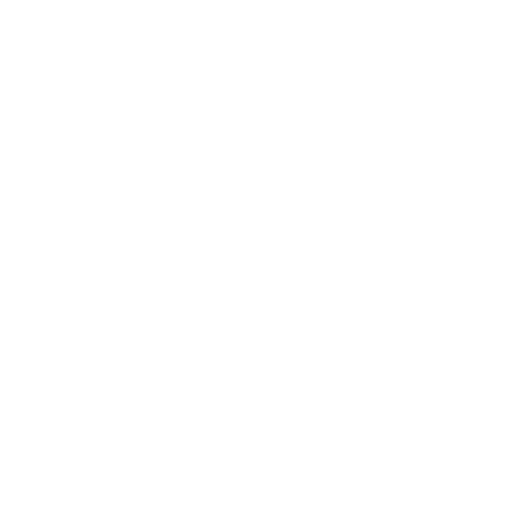

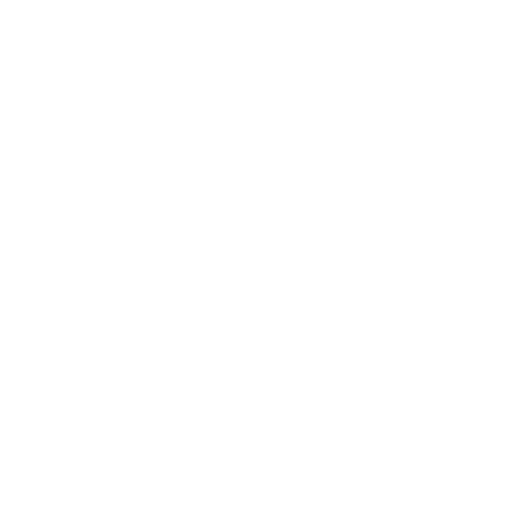

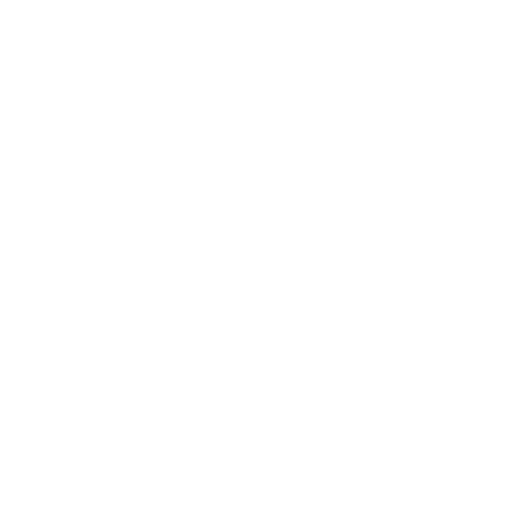

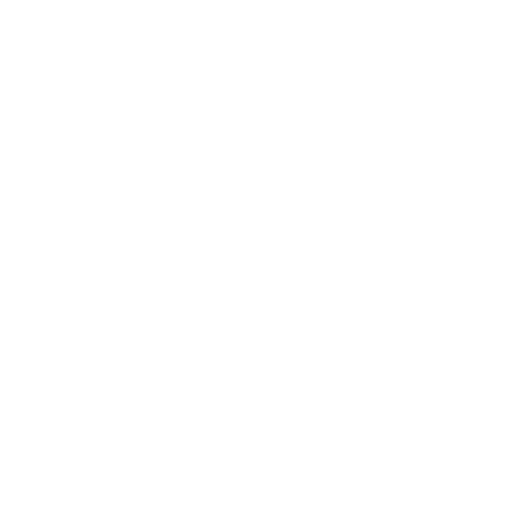

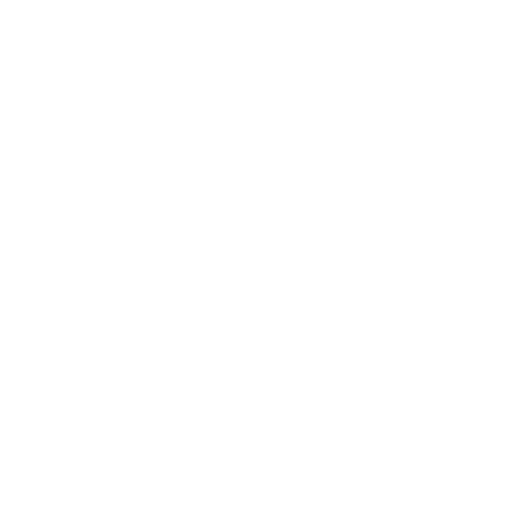

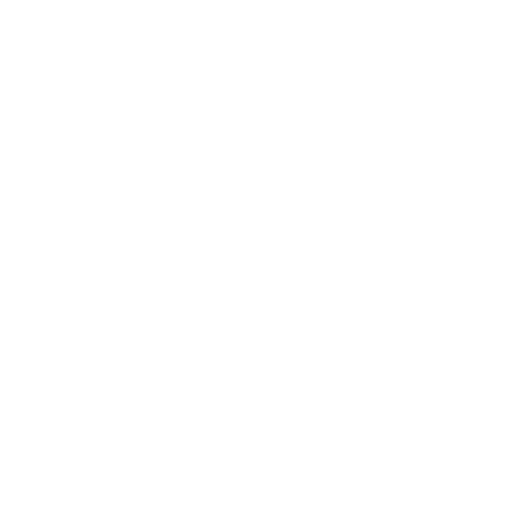

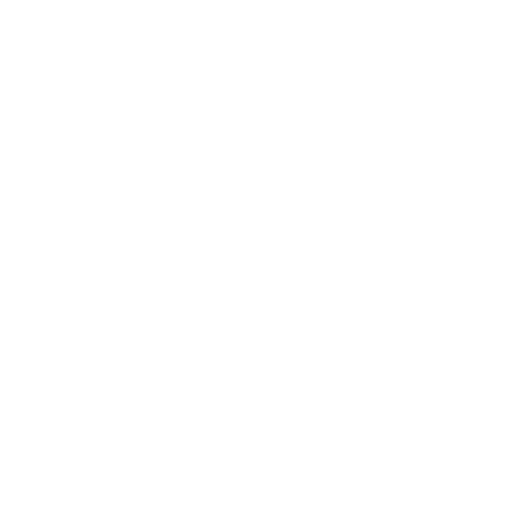

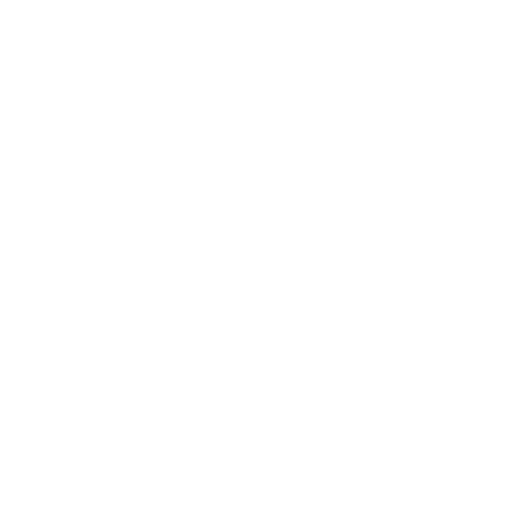

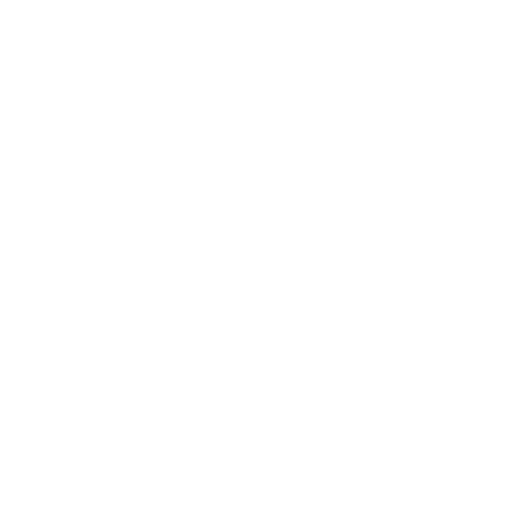

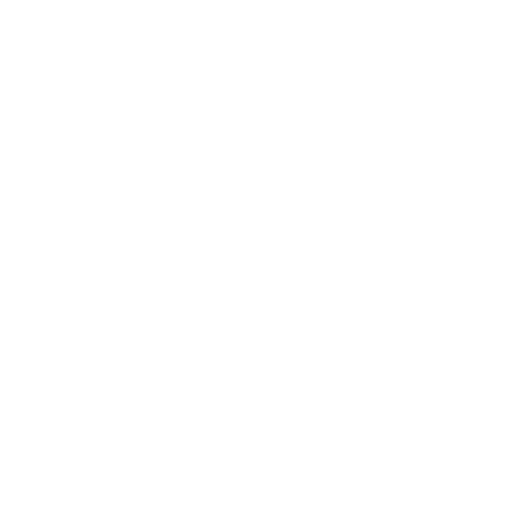

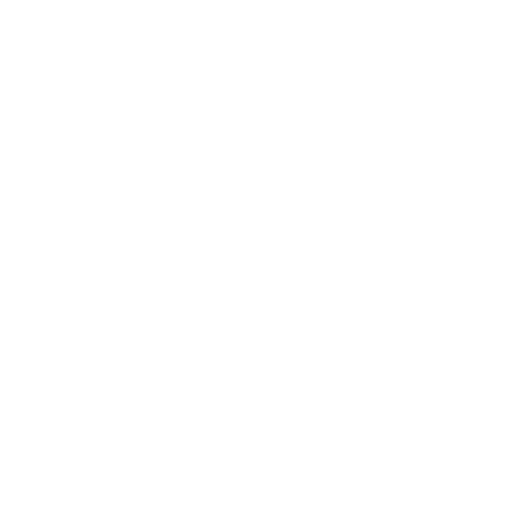

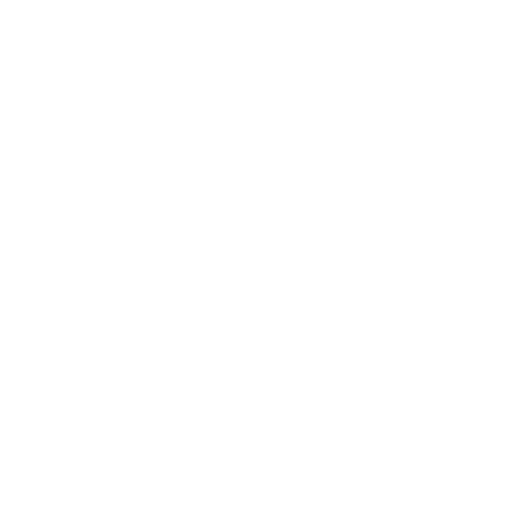

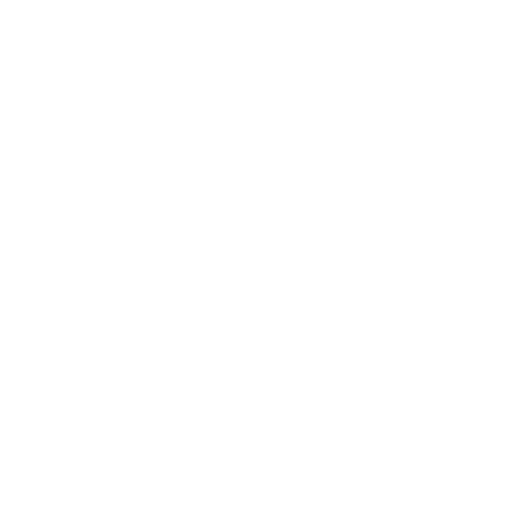

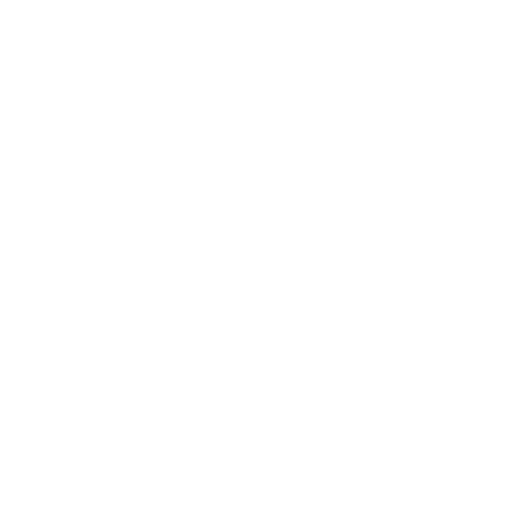

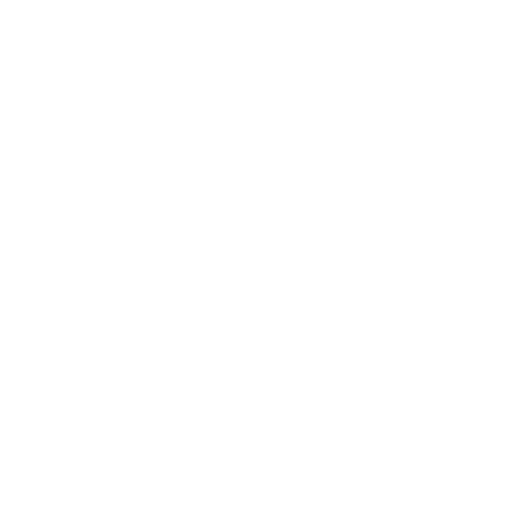

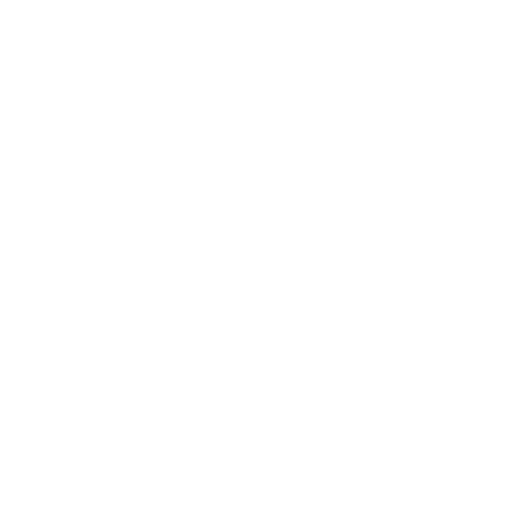

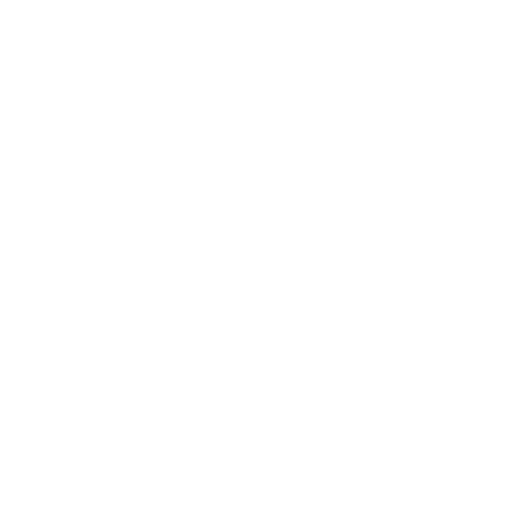

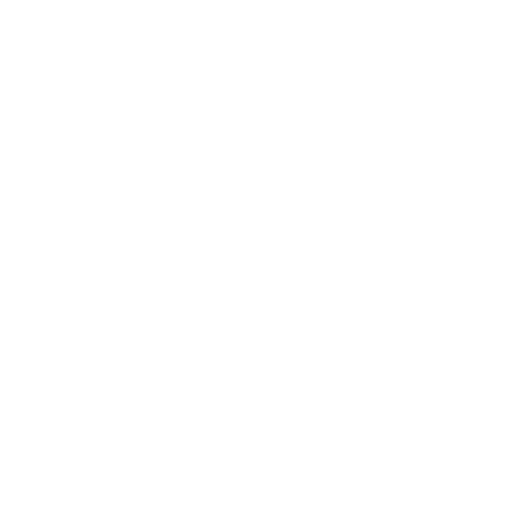

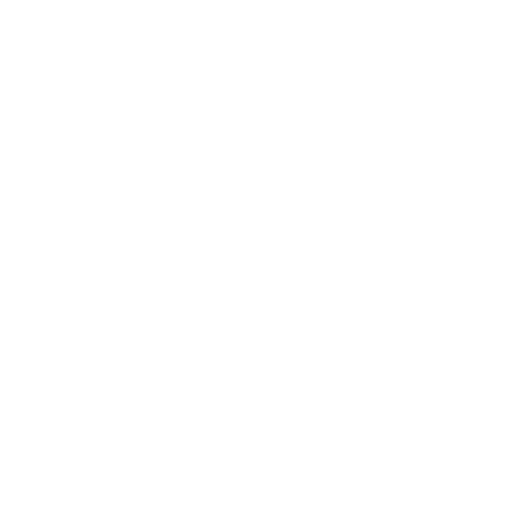

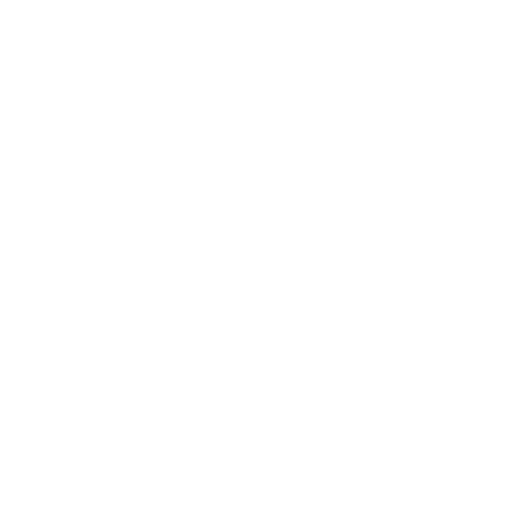

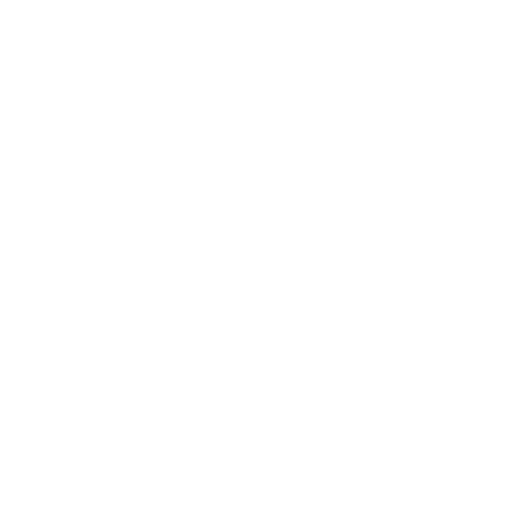

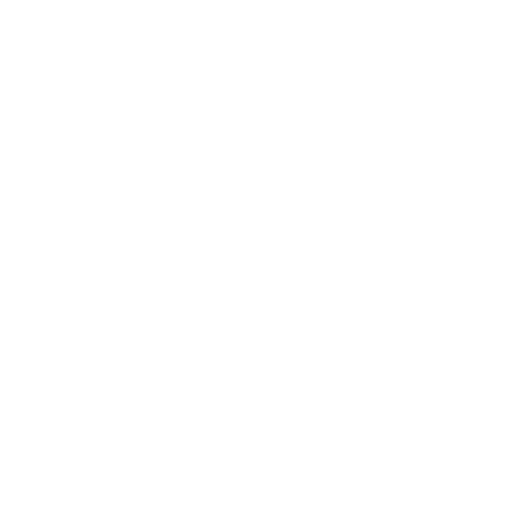

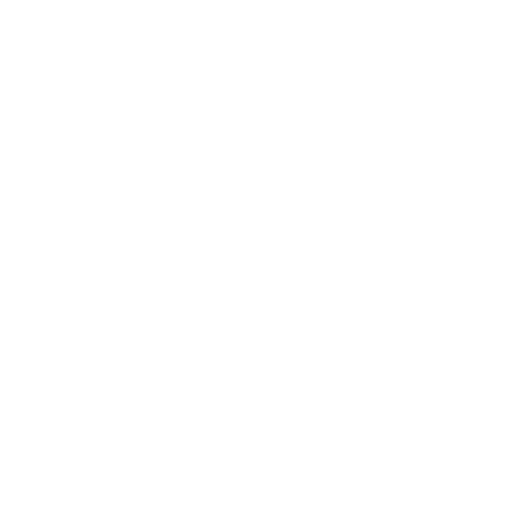

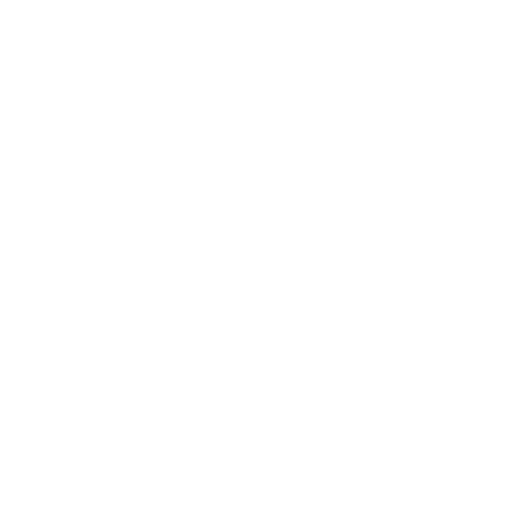

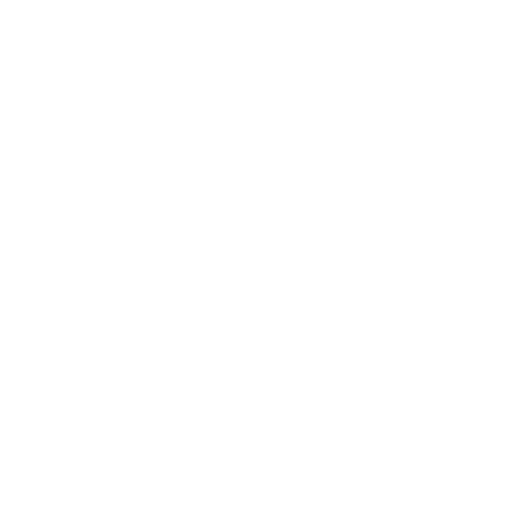

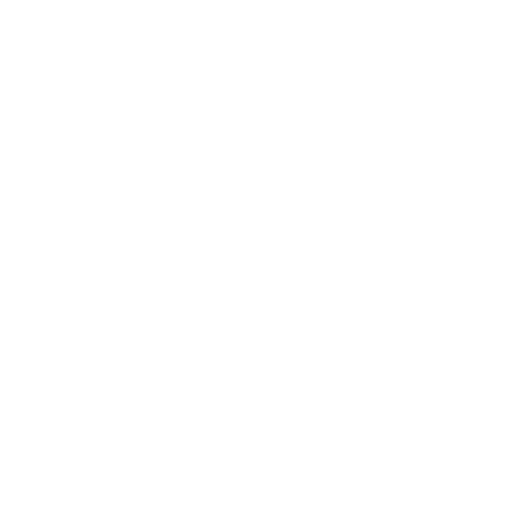

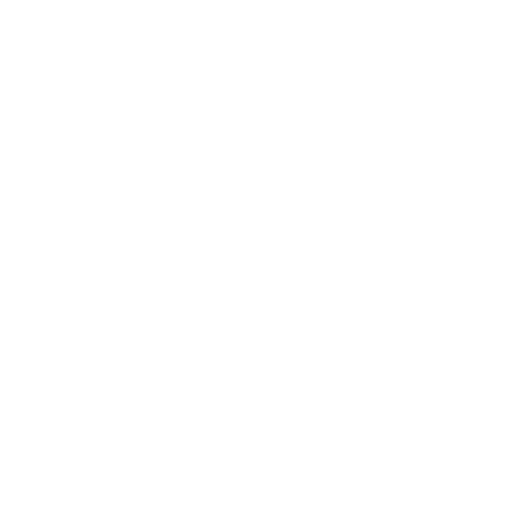

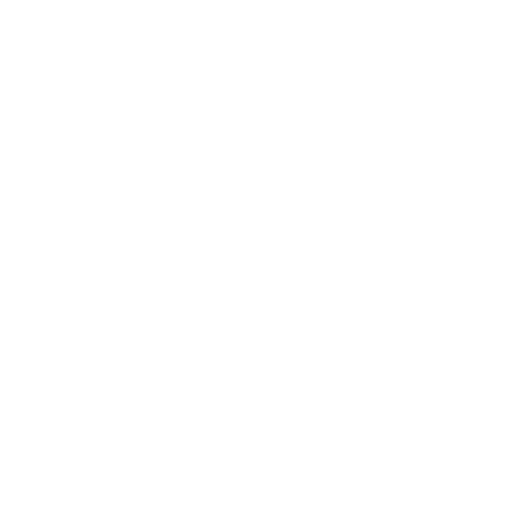

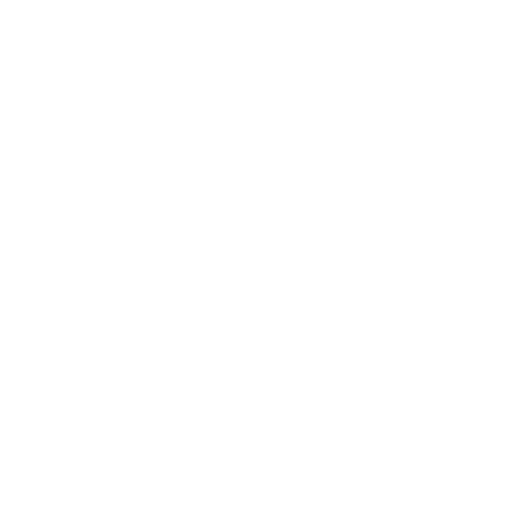

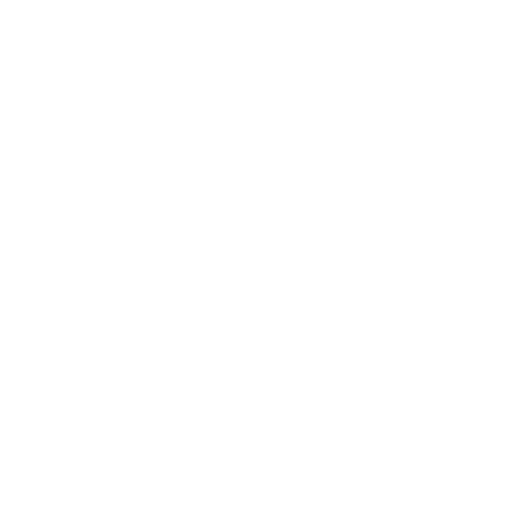

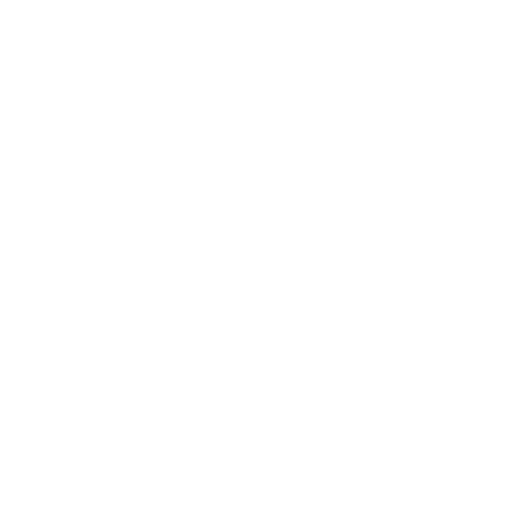

In [16]:
import os
from PIL import Image 
#import cv2
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'

def load(path, dtype=np.float32):
        return np.array(Image.open(path), dtype)

root = '/Users/imke/Downloads/tina/thinvox/predict_dataresult9'
files = os.listdir(root)
files.sort()
lens = len(files)
loss = 0
b = 1
h = 127
num = 70
for i in range(num):
    if i%2 == 0:
        gt = load(os.path.join(root , files[i]),np.int)
        pre = load(os.path.join(root , files[i+1]),np.int)
        #print (files[i])
        gt = (gt[ : , : ] ==255)*1
        pre = (pre[ : , : ]==255)*1
        #print (pre[1,2])
        fig, ax = plt.subplots(1,1, figsize=(7.112,7.112))
        plt.axis('off')
        plt.subplots_adjust(top=1,bottom=0,left=0,right=1,hspace=0,wspace=0) 
        #ax.imshow(pre)
        
        #plt.savefig('/Users/imke/Downloads/tf_unet/prediciton_bool/bool'+str(i+1))
        loss1 = np.sum(np.abs(gt - pre) )/float(gt.shape[0]*gt.shape[1])
        loss1 = 100*loss1
        print ('loss'+str(b)+'=\t%0.4f%%'%loss1)
        loss += loss1
        b += 1
loss = loss/(num/2)
print ('sum_loss=\t%0.4f%%'%loss)

# 数据可视化（loss和error_rate随着epoch不同而变化）

<Figure size 1080x432 with 0 Axes>

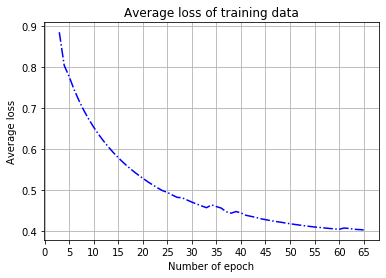

In [53]:
'''
import os 
path1 = '/Users/imke/Downloads/数据117/verification_loss0-17/average_loss.txt'
path2 = '/Users/imke/Downloads/数据117/verification_loss0-17/average_loss1.txt'
ran = []
num = []
for path in [path1, path2]:
    with open (path) as f:
        for line in f:
            tks = line.strip().split('\t')
            ran.append(float(tks[1]))
            num.append(tks[0])
'''
num = []

ran = [0.8848, 0.8039, 0.7768, 0.7454, 0.7182, 0.6941, 0.6726, 0.6532 , 0.6356, 0.6196, 0.6049, 0.5913, 0.5788, 0.5672, 0.5565, 0.5465,0.5372,0.5286,0.5201, 0.5124, 0.5051, 0.4984, 0.494, 0.4877, 0.4818, 0.481, 0.4755, 0.4703, 0.4655, 0.4609, 0.4566, 0.4634, 0.4594, 0.4556, 0.4467, 0.4433, 0.4472, 0.444,  0.4382, 0.4356, 0.4331, 0.4298, 0.4275, 0.4252, 0.4231, 0.4214, 0.4194, 0.4175, 0.4157, 0.4141, 0.4125, 0.411, 0.4095, 0.4085, 0.4072, 0.406, 0.4049, 0.4038, 0.407, 0.406, 0.4041, 0.4033, 0.4024]
num = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]
#ran = tks[1]
fig = plt.figure(figsize=(15, 6))
plt.figure(3)
#plt.subplot(121)
#plt.yticks(range(len(ran)),ran)
plt.plot(num,ran,'b-.')
my_x_ticks = np.arange(0, 70, 5)
plt.xticks(my_x_ticks)
plt.title("Average loss of training data")
plt.xlabel("Number of epoch")
plt.ylabel("Average loss")
plt.grid()
plt.savefig('/Users/imke/Downloads/tf_unet/traning loss_Apri.png')
plt.show()
#plt.subplot(122)


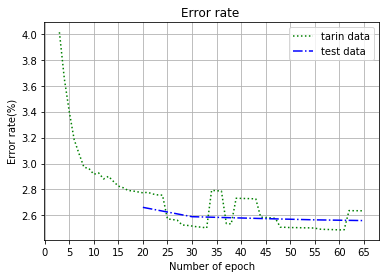

In [54]:
num0 = []

rtn = [4.012, 3.654, 3.401, 3.185, 3.075, 2.971, 2.962, 2.917,  2.927, 2.881, 2.901, 2.862, 2.826, 2.813, 2.792, 2.788, 2.781, 2.774,2.778, 2.765, 2.758, 2.756, 2.573, 2.568, 2.563, 2.526, 2.523, 2.518, 2.512, 2.509, 2.503,2.793, 2.79, 2.788, 2.537, 2.534, 2.732, 2.731, 2.73, 2.729, 2.727, 2.586, 2.584, 2.581, 2.577, 2.509, 2.508, 2.506, 2.506, 2.505, 2.504, 2.504, 2.502, 2.494, 2.492, 2.491, 2.49, 2.488, 2.489, 2.637, 2.636, 2.636, 2.635]
num0 = [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20,21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65]
rtn0 = [2.662,2.590,2.575,2.5657,2.5599]
num1 = [20,30,45,55,65]
plt.plot(num0, rtn, 'g', linestyle = ':', label = 'tarin data')
plt.plot(num1,rtn0,'b-.', label = 'test data')
my_x_ticks = np.arange(0, 70, 5)
plt.xticks(my_x_ticks)
plt.title("Error rate ")
plt.xlabel("Number of epoch")
plt.ylabel("Error rate(%)")
plt.legend()
plt.grid()
plt.savefig('/Users/imke/Downloads/tf_unet/error_Apri.png')
plt.show()

In [1]:
import os 
path1 = '/Users/imke/Downloads/数据117/verification_loss0-17/loss.txt'
path2 = '/Users/imke/Downloads/数据117/verification_loss0-17/loss1.txt'
ren = []
num0 = []
for path in [path1, path2]:
    with open (path) as f:
        for line in f:
            tks = line.strip().split('\t')
            ren.append(float(tks[0]))
            num0.append(float(tks[1]))
print (ren)
print (num0)

[86.741, 4.012, 3.654, 3.401, 3.185, 3.075, 2.971, 2.917, 3.069, 2.962, 2.927, 2.881, 2.862, 2.826, 2.813, 2.792, 2.788, 2.781, 2.774]
[1.4259, 0.7896, 0.7554, 0.7261, 0.7002, 0.6774, 0.6569, 0.6386, 0.6772, 0.6567, 0.6385, 0.6218, 0.6065, 0.5925, 0.5795, 0.5676, 0.5565, 0.5462, 0.5366]


In [3]:
import os 
path1 = '/Users/imke/Downloads/data_2020_4_4/round1_data/loss.txt'
ren = []
num0 = []
l = []
i = 20
for path in [path1]:
    with open (path) as f:
        for line in f:
            tks = line.strip().split('\t')
            ren.append(float(tks[0]))
            num0.append(float(tks[1]))
            i = i+1
            l.append(i)
print(l)
print (ren)
print (num0)

[21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69]
[2.778, 2.765, 2.758, 2.756, 2.573, 2.568, 2.563, 2.526, 2.523, 2.518, 2.512, 2.509, 2.503, 2.801, 2.793, 2.79, 2.788, 2.537, 2.534, 2.736, 2.732, 2.731, 2.73, 2.729, 2.727, 2.586, 2.584, 2.581, 2.577, 2.509, 2.508, 2.506, 2.506, 2.505, 2.504, 2.504, 2.502, 2.494, 2.492, 2.491, 2.49, 2.488, 2.489, 2.637, 2.636, 2.636, 2.635, 2.635, 2.635]
[0.5201, 0.5124, 0.5051, 0.4984, 0.494, 0.4877, 0.4818, 0.481, 0.4755, 0.4703, 0.4655, 0.4609, 0.4566, 0.4634, 0.4594, 0.4556, 0.452, 0.4467, 0.4433, 0.4472, 0.444, 0.441, 0.4382, 0.4356, 0.4331, 0.4298, 0.4275, 0.4252, 0.4231, 0.4214, 0.4194, 0.4175, 0.4157, 0.4141, 0.4125, 0.411, 0.4095, 0.4098, 0.4085, 0.4072, 0.406, 0.4049, 0.4038, 0.407, 0.406, 0.405, 0.4041, 0.4033, 0.4024]


# prediction_bool用来装单个预测图片和拼接图片进行对比

In [44]:
import math
from PIL import Image

column = 3
width = 512
height = 512
size = (512, 512)
hh = 101
list_im = ['/Users/imke/Downloads/tina/thinvox/predict_dataresult9/Series085_s0_z'+str(hh)+'_ch00_mask.tif',
           '/Users/imke/Downloads/tina/thinvox/predict_dataresult9/Series085_s0_z'+str(hh)+'_ch00.tif',
           '/Users/imke/Downloads/tina/thinvox/compare_9/compare'+str(hh)+'.tif']
list_im = list_im
imgs = [Image.open(i) for i in list_im]

row_num = math.ceil(len(imgs)/column)
target = Image.new('RGB', (width*column, height*row_num))
for i in range(len(list_im)):
    if i % column == 0:
        end = len(list_im) if i + column > len(list_im) else i + column 
        for col, image in enumerate(imgs[i:i+column]):
            target.paste(image, (width*col, height*(i//column), 
                                 width*(col + 1), height*(i//column + 1)))   

#target = target[:,:512]
print(target.size)
#target.show()
target.save('/Users/imke/Downloads/tina/thinvox/0.png')

(1536, 512)


In [3]:
print((2.8027147371444983+2.5266625969548926+2.356542660155128)/3)

2.561973331418173


# 缩小tina出来的标签mask图片

(472, 472)
(472, 472)
(472, 472)
(472, 472)
(472, 472)
(472, 472)
(472, 472)
(472, 472)
(472, 472)
(472, 472)
(472, 472)
(472, 472)
(472, 472)
(472, 472)
(472, 472)
(472, 472)
(472, 472)
(472, 472)
(472, 472)
(472, 472)
(472, 472)
(472, 472)


/Users/imke/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  


(472, 472)
(472, 472)
(472, 472)
(472, 472)
(472, 472)
(472, 472)
(472, 472)
(472, 472)
(472, 472)
(472, 472)
(472, 472)
(472, 472)
(472, 472)


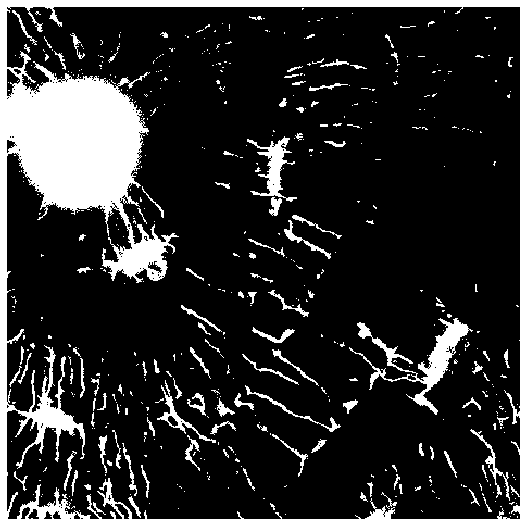

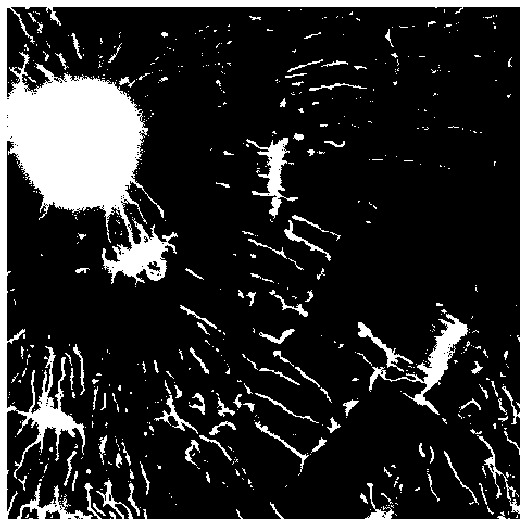

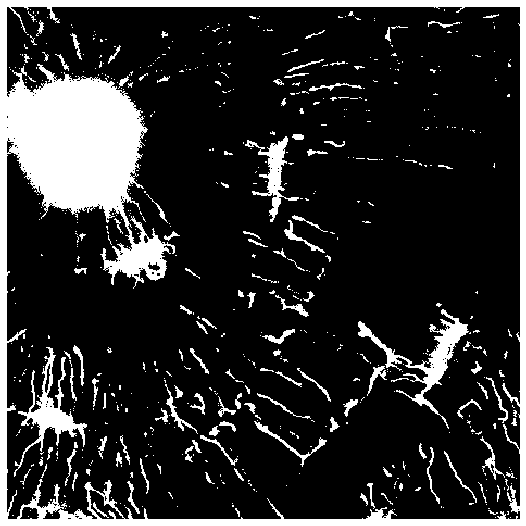

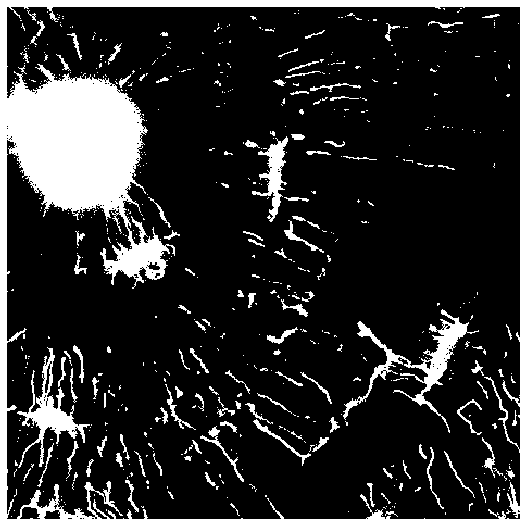

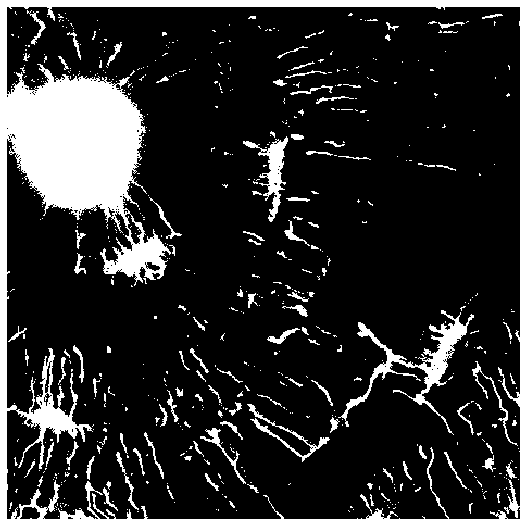

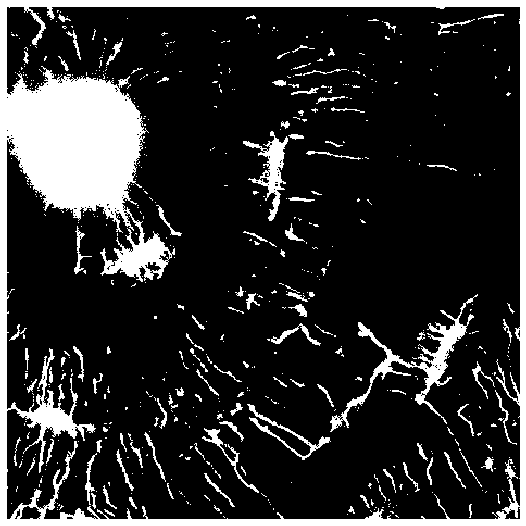

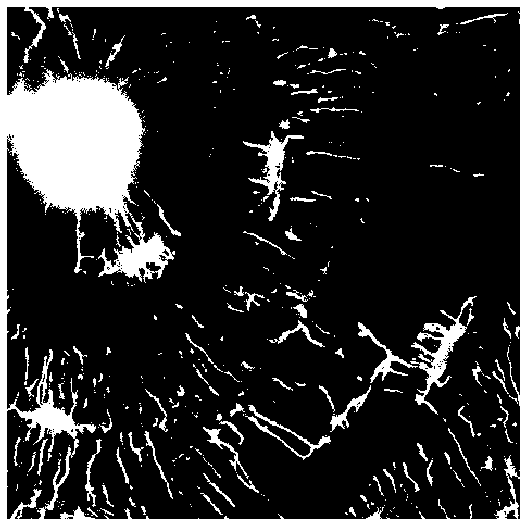

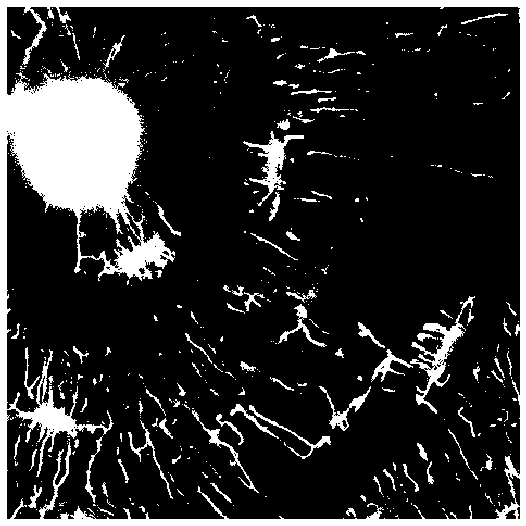

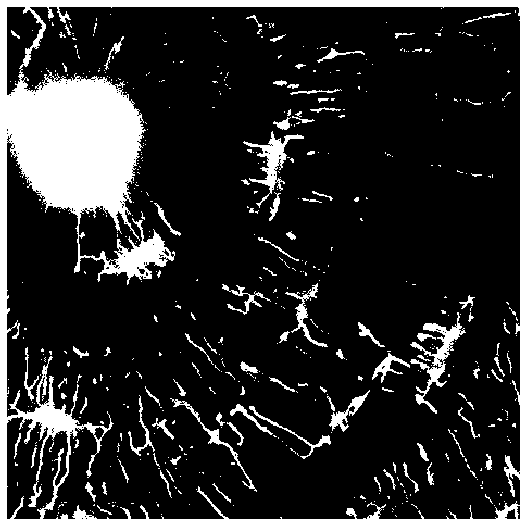

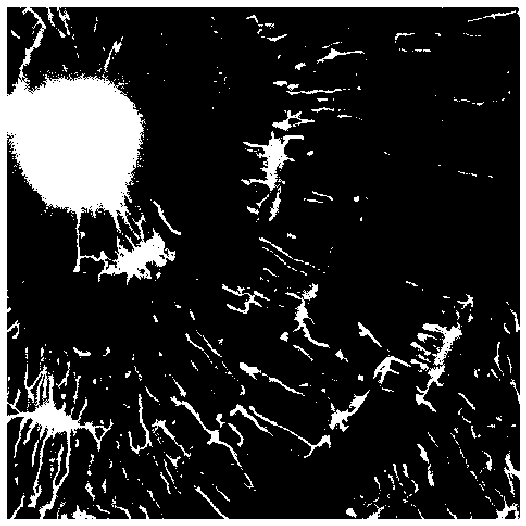

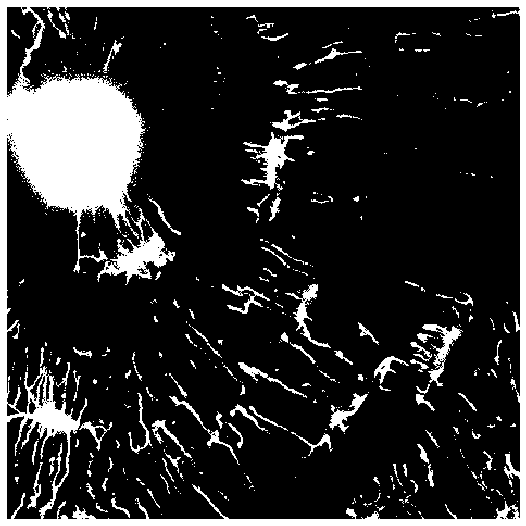

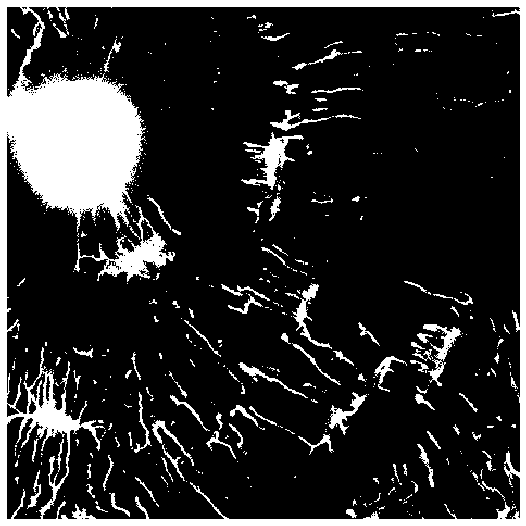

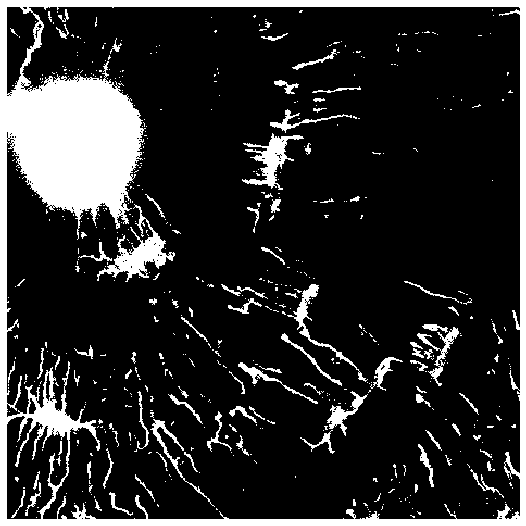

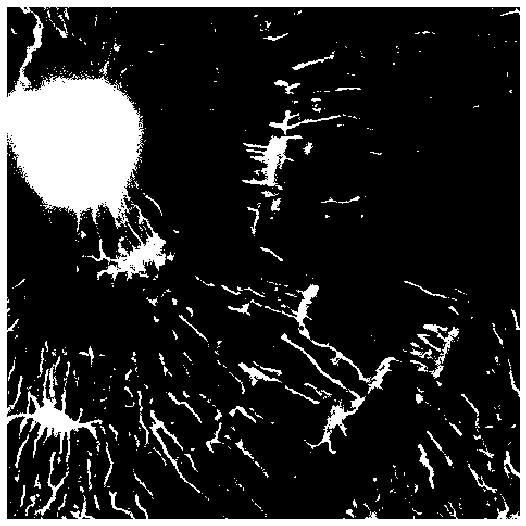

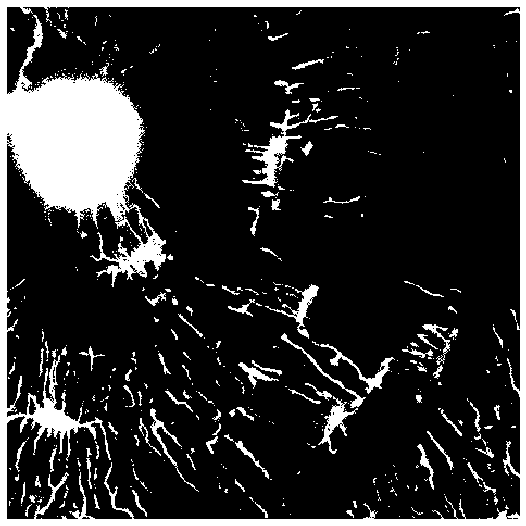

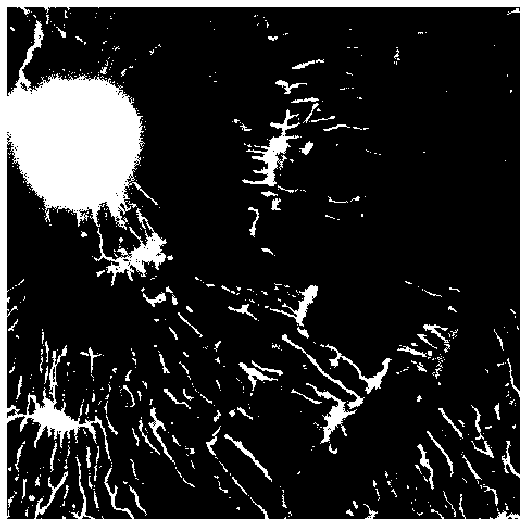

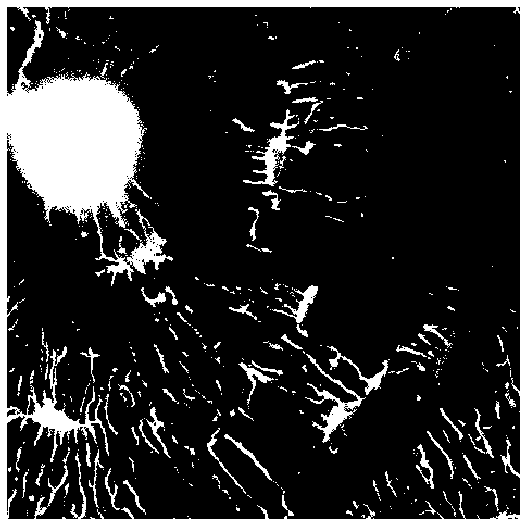

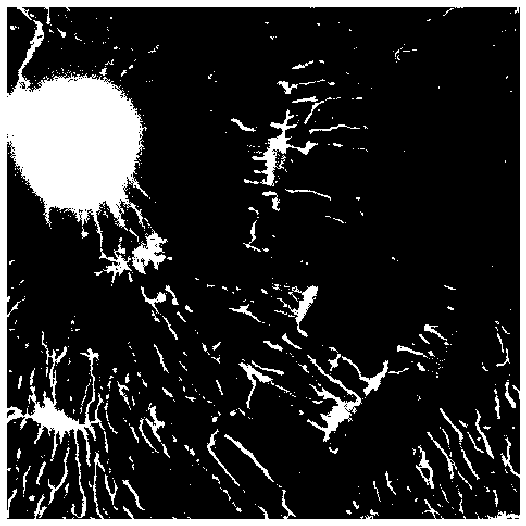

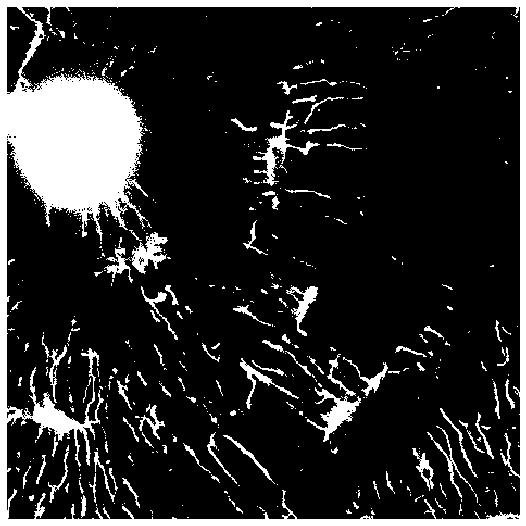

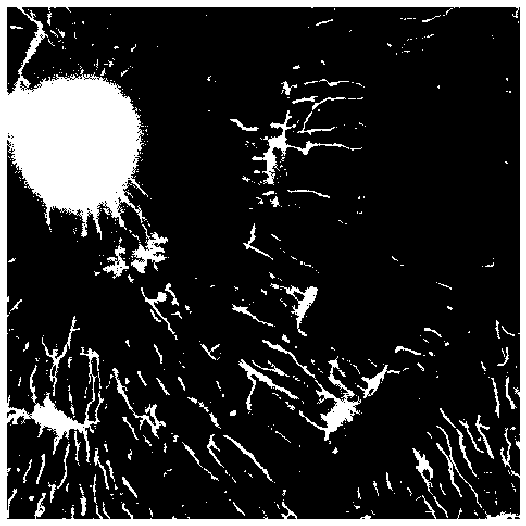

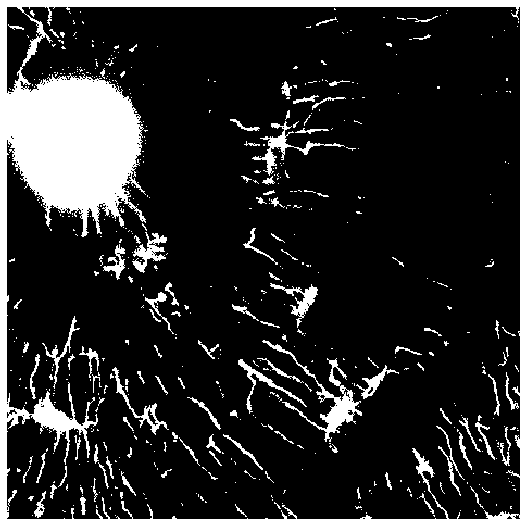

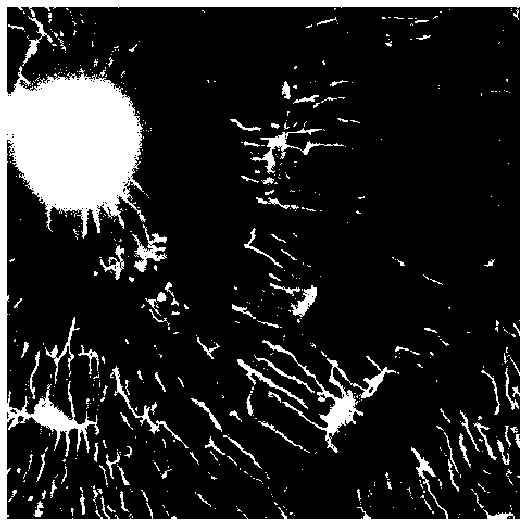

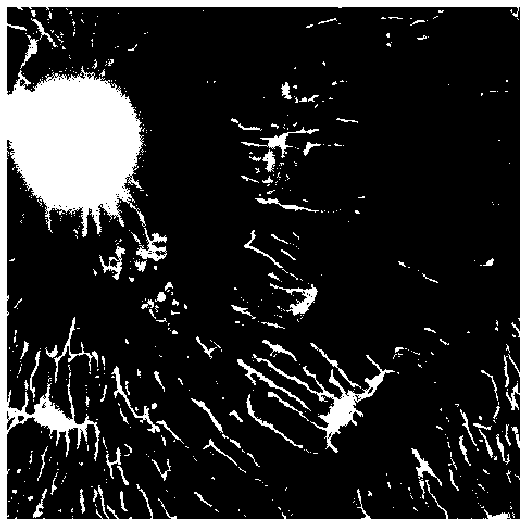

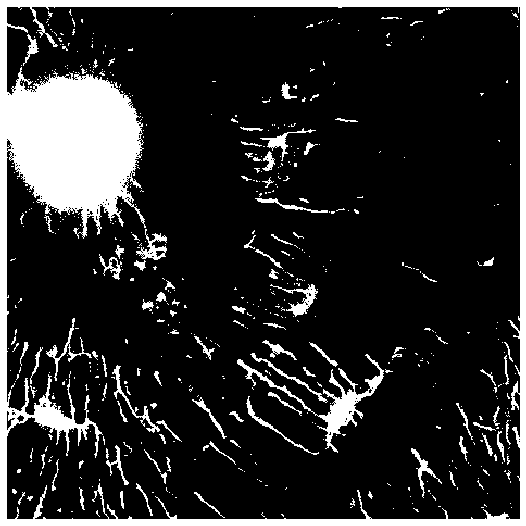

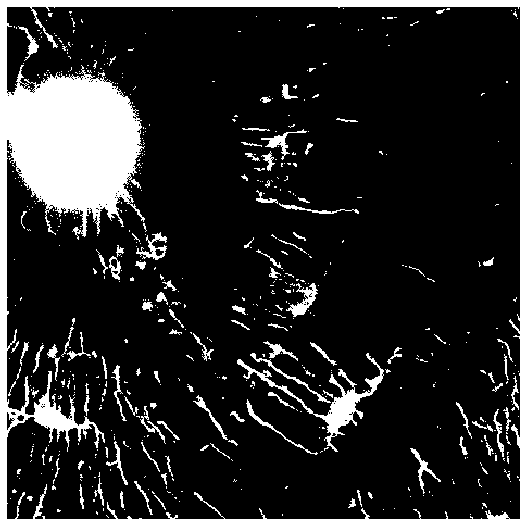

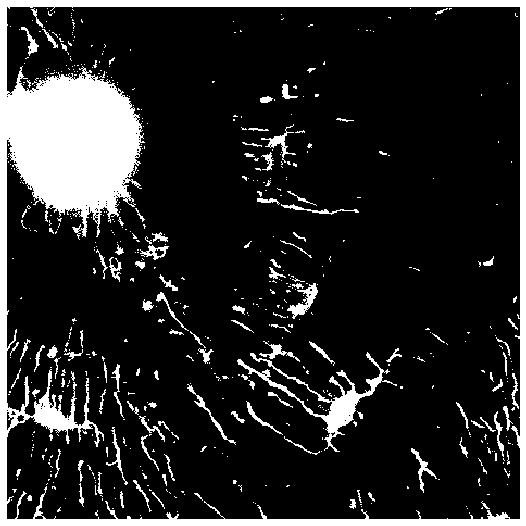

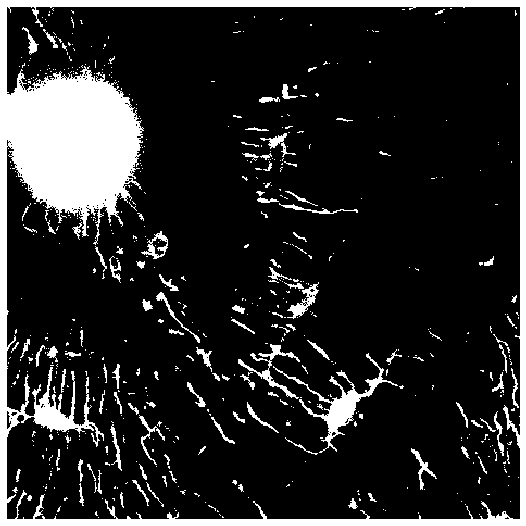

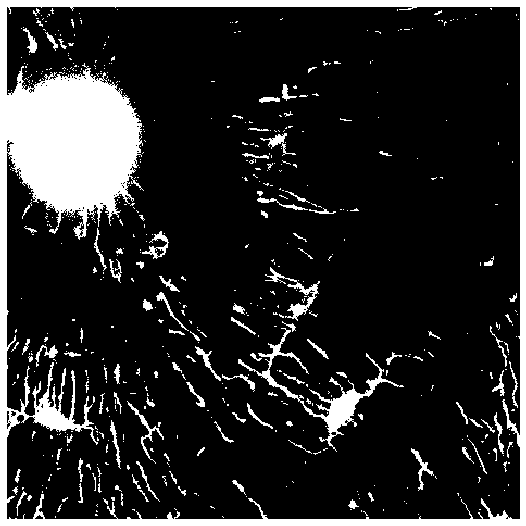

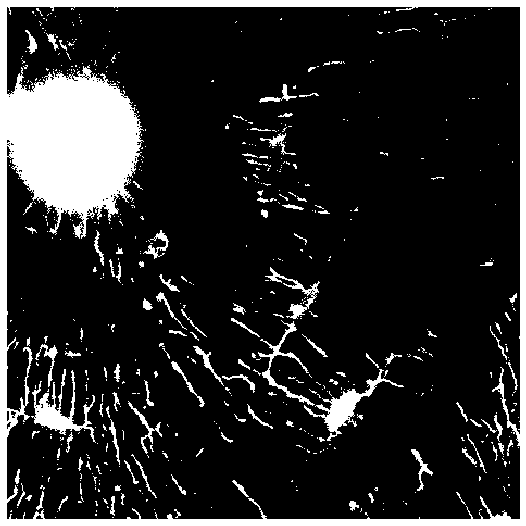

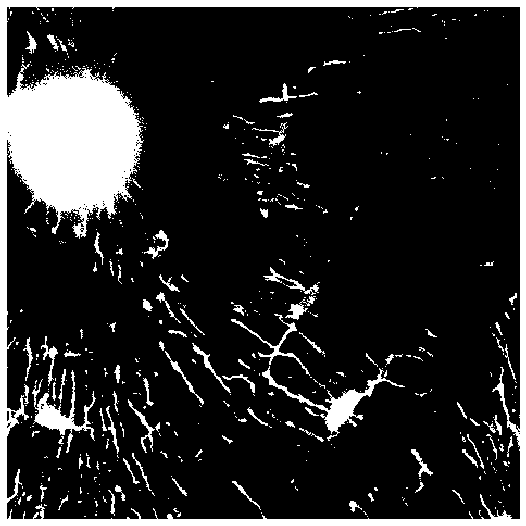

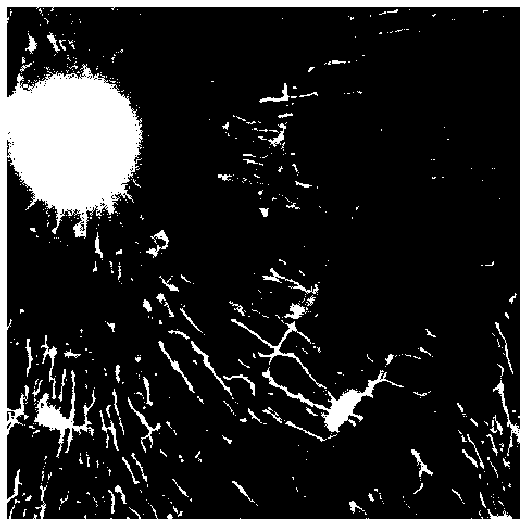

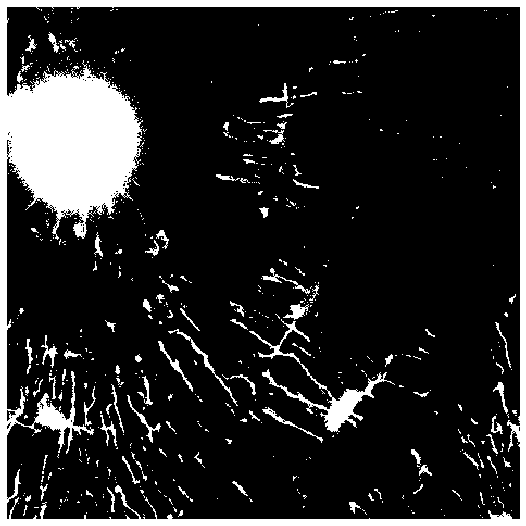

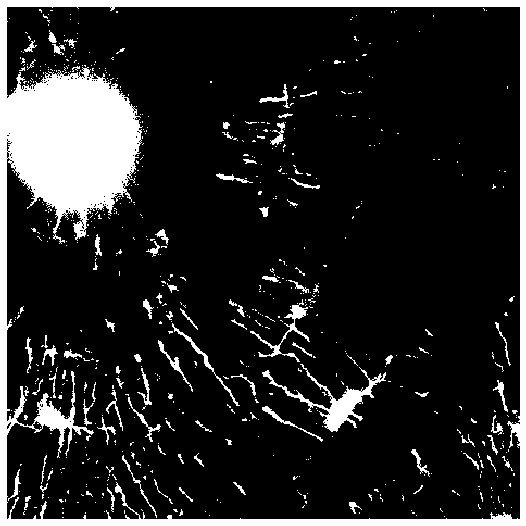

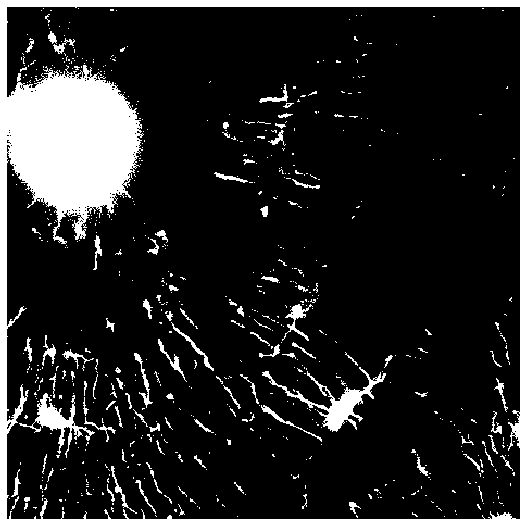

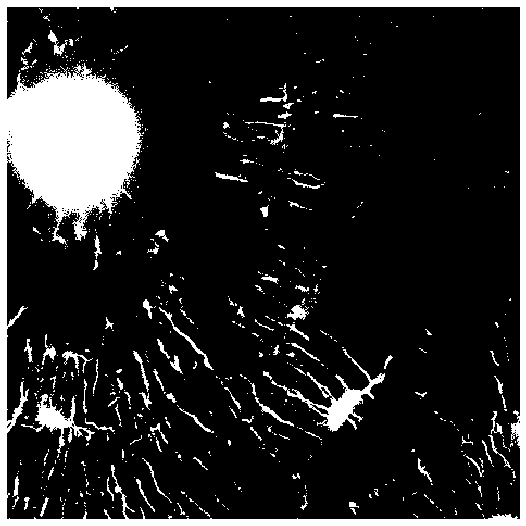

In [14]:
from PIL import Image
def load(path, dtype=np.float32):
        return np.array(Image.open(path), dtype)
for i in range(35):
    k = 101+i
    a = load('/Users/imke/Downloads/tina/thinvox/prediction_TIF_copy/Series085_s0_z'+str(k)+'_ch00_mask.tif')
    a = a[20:492,20:492]
    fig, ax = plt.subplots(1,1, figsize=(7.112,7.112))
    plt.axis('off')
    plt.subplots_adjust(top=1,bottom=0,left=0,right=1,hspace=0,wspace=0) 
    #ax.imshow(a)
    plt.savefig('/Users/imke/Downloads/tina/thinvox/prediction_TIF_copy/Series085_s0_z'+str(k)+'_ch00_mask.tif')
    img = Image.open('/Users/imke/Downloads/tina/thinvox/prediction_TIF_copy/Series085_s0_z'+str(k)+'_ch00_mask.tif').convert('L')
    #g = 101+i
    # (g)
    img.save('/Users/imke/Downloads/tina/thinvox/prediction_TIF_copy/Series085_s0_z'+str(k)+'_ch00_mask.tif')
    #print(a.shape)

## 对比标签图片unet训练出来的图片之间的差异

In [19]:
from PIL import Image
from PIL import ImageChops 

def compare_images(path_one, path_two, diff_save_location):
    """
    比较图片，如果有不同则生成展示不同的图片
 
    @参数一: path_one: 第一张图片的路径
    @参数二: path_two: 第二张图片的路径
    @参数三: diff_save_location: 不同图的保存路径
    """
    image_one = Image.open(path_one)
    image_two = Image.open(path_two)
    try: 
        diff = ImageChops.difference(image_one, image_two)
 

        if diff.getbbox() is None:
        # 图片间没有任何不同则直接退出
            print("【+】We are the same!")
        else:
            diff.save(diff_save_location)
    except ValueError as e:
        text = ("表示图片大小和box对应的宽度不一致，参考API说明：Pastes another image into this image."
                "The box argument is either a 2-tuple giving the upper left corner, a 4-tuple defining the left, upper, "
                "right, and lower pixel coordinate, or None (same as (0, 0)). If a 4-tuple is given, the size of the pasted "
                "image must match the size of the region.使用2纬的box避免上述问题")
        print("【{0}】{1}".format(e,text))

gg = 7
for i in range (101,136):
    compare_images("/Users/imke/Downloads/tina/thinvox/predict_dataresult"+str(gg)+"/Series085_s0_z"+str(i)+"_ch00_mask.tif",
                   "/Users/imke/Downloads/tina/thinvox/predict_dataresult"+str(gg)+"/Series085_s0_z"+str(i)+"_ch00.tif",
                   "/Users/imke/Downloads/tina/thinvox/compare_"+str(gg)+"/compare"+str(i)+".tif")



In [35]:
from PIL import Image
def load(path, dtype=np.float32):
        return np.array(Image.open(path), dtype)
a = load("/Users/imke/Downloads/tina/thinvox/0.png")
b = load("/Users/imke/Downloads/tina/thinvox/1.png")
c = load("/Users/imke/Downloads/tina/thinvox/2.png")
d = a+b+c
print(d.shape)

(512, 1536, 3)
